In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [4]:
# Read data from csv
DATA_PATH = '../data/games_info.csv'
df = pd.read_csv(DATA_PATH)

In [5]:
df.head()

,Title,Release date,Platform,Other platforms,Publisher,Developer,Genres,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews
0,The Legend of Zelda: Ocarina of Time,"Nov 23, 1998",Nintendo 64,NaN,Nintendo,Nintendo,"Action Adventure,Fantasy",E,1 Player,99.0,22,9.1,7359
1,Tony Hawk's Pro Skater 2,"Sep 20, 2000",PlayStation,"iPhone/iPad,PC",Activision,Neversoft Entertainment,"Sports,Alternative,Skateboarding",T,1-2,98.0,19,7.4,845
2,Grand Theft Auto IV,"Apr 29, 2008",PlayStation 3,"PC,Xbox 360",Rockstar Games,Rockstar North,"Action Adventure,Modern,Modern,Open-World",M,1 Player,98.0,64,7.8,4735
3,SoulCalibur,"Sep 8, 1999",Dreamcast,NaN,Namco,Namco,"Action,Fighting,3D",T,1-2,98.0,24,8.4,394
4,Grand Theft Auto IV,"Apr 29, 2008",Xbox 360,"PC,PlayStation 3",Rockstar Games,Rockstar North,"Action Adventure,Modern,Modern,Open-World",M,1 Player,98.0,86,8.0,3671


Đếm các giá trị null trong dataframe

In [97]:
df.isnull().sum()

Title                         0
Release date                  0
Platform                      0
Other platforms             480
Publisher                     0
Developer                     1
Genres                        0
Rating                       87
Number of players           218
Metascore                     0
Number of critic reviews      0
User Score                    0
Number of user reviews        0
dtype: int64

## Tiền xử lý dữ liệu

Thay thế các giá trị nan trong cột `Rating` bằng giá trị xuất hiện nhiều nhất trong cột

Chuyển các giá trị trong cột `Rating` từ string sang integer như trong phần tiền xử lý dữ liệu

In [6]:
df['Rating'] = df['Rating'].fillna(df['Rating'].mode()[0])
def handle_rating(x):
    if x == 'E':
        return str(3)
    if x == 'K-A':
        return str(6)
    if x == 'E10+':
        return str(10)
    if x == 'T':
        return str(13)
    if x == 'M':
        return str(17)
    if x == 'AO':
        return str(18)

df['Rating'] = df['Rating'].astype('str').apply(lambda x: handle_rating(x)).astype(int)

* Cột `Release date` lấy giá trị year.
* Thêm cột `Number of companies` là số lượng công ty tham gia phát triển.
* Cột `Genres` mở rộng thành nhiều cột khác, mỗi genre là một cột và thể hiện bằng giá trị boolean.
* Cột `Number of players` lấy giá trị số lượng người chơi cao nhất trong chuỗi string; riêng 'Massively Multiplayer', 'Online Multiplayer' thay bằng giá trị 100l sau đó thay thế các giá trị nan trong cột bằng giá trị xuất hiện nhiều nhất trong cột.
* Bỏ cột `Genres`, `Other platforms`, `Title`.
* Sử dụng LabelEncoder để chuyển giá trị từ object sang integer của các cột có kiểu object còn lại.

In [7]:

# Xử lý cột Release date
df['Release date'] = df['Release date'].astype('str').apply(lambda x: x[-4:]).astype(int)

# Xử lý cột Developer và thêm cột Number of companies
list_n_company = []
df['Developer'] = df['Developer'].fillna("Self Developer")
for i in range(len(df)):
    n_company = len(df['Developer'][i].split(','))
    list_n_company.append(n_company)
df['Number of companies'] = list_n_company

# Xử lý cột Genres
genres_df = df['Genres'].str.split(',', expand=True).apply(pd.value_counts, axis=1).fillna(0)
for col in genres_df:
    genres_df[col] = genres_df[col].astype(bool)

df = pd.concat([df, genres_df], axis=1, join='inner')

# Xử lý cột Number of players
def handle_n_players(x):
    if x in ['Massively Multiplayer', 'Online Multiplayer']:
        return str(100)

    tokens = x.replace('+', ' ').replace('-', ' ').split()
    max_player = 1
    for token in tokens:
        if token.isdigit():
            max_player = max(max_player, int(token))
    return str(max_player)

df['Number of players'] = df['Number of players'].astype('str').apply(lambda x: handle_n_players(x)).astype(int)
df['Number of players'] = df['Number of players'].fillna(df['Number of players'].mode()[0])

# Loại bỏ cột Gerens, Other platforms, Title
df = df.drop(columns=['Genres', 'Other platforms', 'Title'])

# Xử lý các cột object còn lại
for data in df.columns:
    if df[data].dtype=='object':
        l_en = LabelEncoder()  # converting line
        df[data] = l_en.fit_transform(df[data]) # converting line ##important

Giá trị của dataframe sau khi qua xử lý dữ liệu

In [8]:
df.head(5)

,Release date,Platform,Publisher,Developer,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews,...,Tycoon,Vehicle,Vertical,Virtual,Virtual Life,Visual Novel,WWII,Wargame,Western-Style,Wrestling
0,1998,5,127,266,3,1,99.0,22,9.1,7359,...,False,False,False,False,False,False,False,False,False,False
1,2000,8,13,259,13,2,98.0,19,7.4,845,...,False,False,False,False,False,False,False,False,False,False
2,2008,10,151,329,17,1,98.0,64,7.8,4735,...,False,False,False,False,False,False,False,False,False,False
3,1999,2,121,252,13,2,98.0,24,8.4,394,...,False,False,False,False,False,False,False,False,False,False
4,2008,18,151,329,17,1,98.0,86,8.0,3671,...,False,False,False,False,False,False,False,False,False,False


## Đặt bài toán cần giải quyết

#### Bài toán nhóm đặt ra là Sử dụng các Classification model để phân loại giá trị User score

Lấy điểm giá trị phân chia là <b>8.3</b>, vì tại giá trị này phân bố của dữ liệu là không có sự chênh lệch đáng kể

In [9]:
def classify_userscore(x):
    if x < 8.3:
        return 0
    if x >= 8.3:
        return 1

df['User Score'] = df['User Score'].apply(lambda x: classify_userscore(x)).astype(int)

<AxesSubplot: >

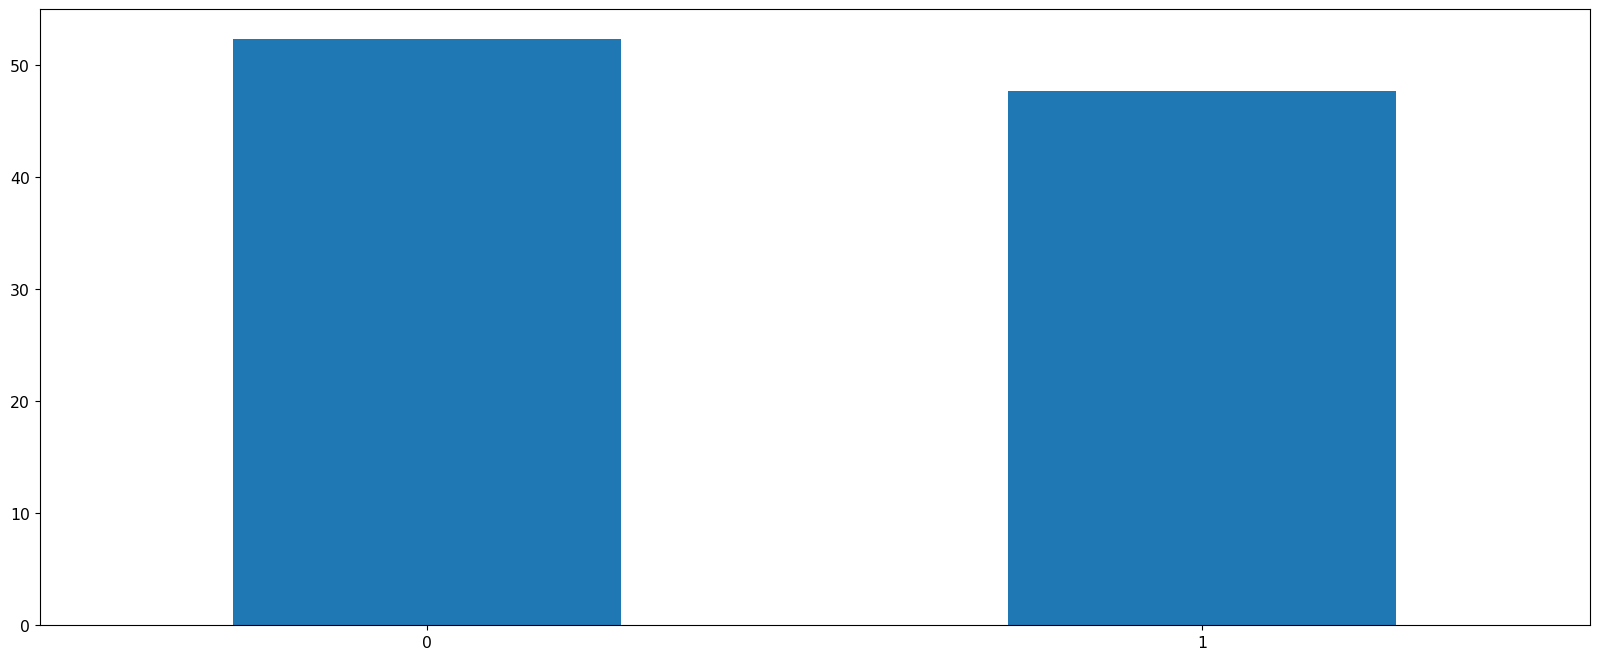

In [10]:
sr = df['User Score'].value_counts(normalize=True) * 100
sr.plot.bar(rot = 0)

Phân chia dữ liệu thành 2 set: `training set` (75%) và `testing set` (25%)

In [11]:
#User score is the target so we will spilt with it
x = df.drop(['User Score'] , axis = 1).values
y= df['User Score'].values
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state=42)

Scale dữ liệu sử dụng <b>RobustScaler</b>

In [12]:
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(x_train)
x_test = ro_scaler.fit_transform(x_test)
r, c = x_train.shape
r2 ,c2 = x_test.shape
print (f"x_train = {r} and y_train = {y_train.shape} ")
print (f"x_test = {r2} and y_test = {y_test.shape} ")

x_train = 1123 and y_train = (1123,) 
x_test = 375 and y_test = (375,) 


## Mô hình hoá dữ liệu

Nhóm sử dụng 3 classification model: `Logistic Regression`, `K Neighbors Classifier`, `Decision Tree Classifier` để phân loại <b>User score</b>

Sử dụng `GridSearchCV` để xác định các hyperparameter cho model

### 1. Logistic Regression

In [14]:
lr = LogisticRegression()

In [139]:
list_C = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

tuning_dict = dict(
    C = list_C,
    max_iter = [2000]
)

In [140]:
# Khởi tạo grid search cross validation
search = GridSearchCV(lr, tuning_dict, verbose=1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [141]:
best_hp.best_params_

{'C': 6, 'max_iter': 2000}

In [15]:
lr_model_tuning = LogisticRegression(C = 6, max_iter=2000)
lr_model_tuning.fit(x_train , y_train)

LogisticRegression(C=6, max_iter=2000)

Giá trị chính xác của model trên `training set`

In [16]:
lr_model_tuning.score(x_train , y_train)

0.7631344612644702

Giá trị chính xác của model trên `testing set`

In [17]:
lr_model_tuning.score(x_test, y_test)

0.76

So sánh 10 giá trị đầu tiên giữa kết quả thực tế (Y_test) và kết quả dự đoán (Y_pred)

In [18]:
Y_pred = lr_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,1,0
6,1,1
7,0,1
8,1,0
9,0,1


Biểu đồ thể hiện kết quả thực tế và kết quả dự đoán của 80 giá trị đầu tiên 

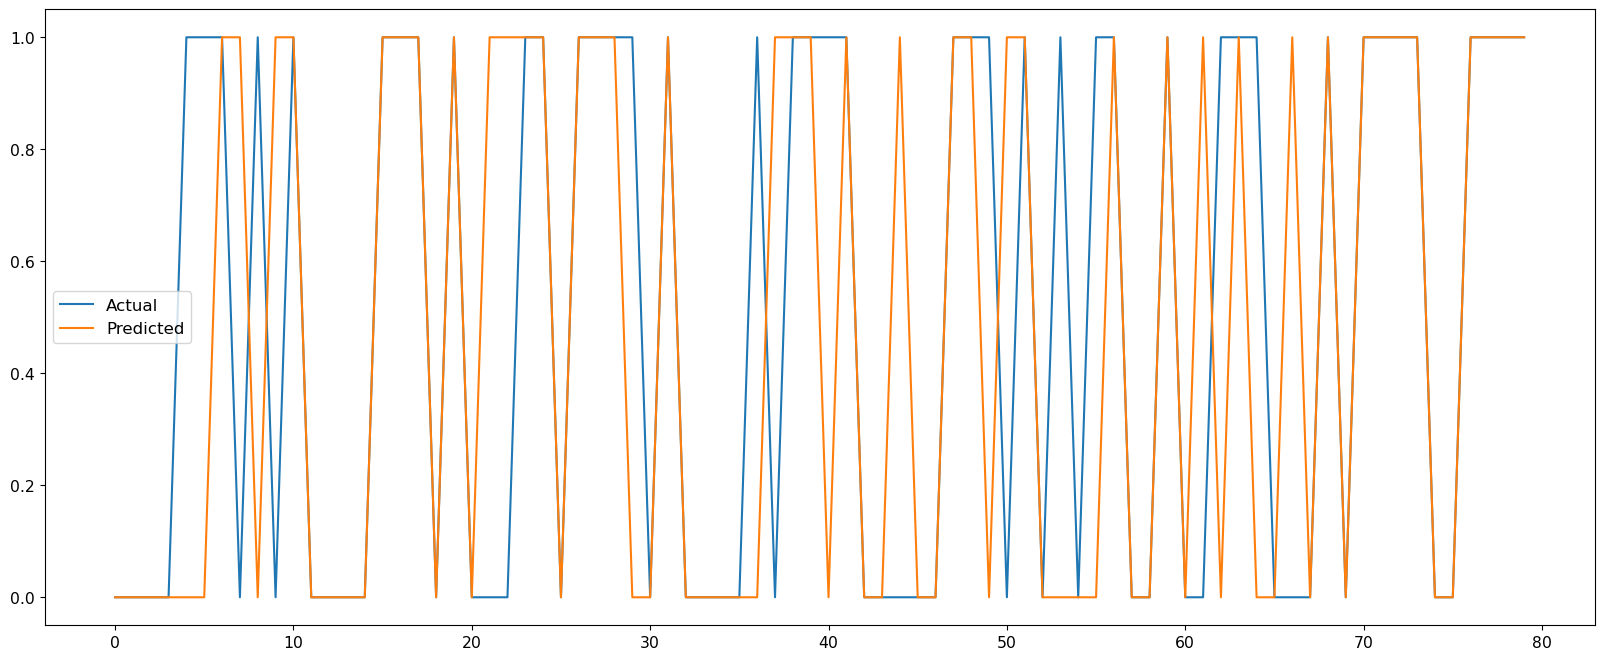

In [19]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

### 2. K Neighbors Classifier

In [155]:
knn = KNeighborsClassifier()

In [156]:
k_range = list(range(1, 20))

tuning_dict = dict(
    n_neighbors = k_range,
)

In [157]:
# Khởi tạo grid search cross validation
search = GridSearchCV(knn, tuning_dict, verbose = 1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [158]:
best_hp.best_params_

{'n_neighbors': 18}

In [20]:
knn_model_tuning = KNeighborsClassifier(n_neighbors = 18)
knn_model_tuning.fit(x_train , y_train)

KNeighborsClassifier(n_neighbors=18)

Giá trị chính xác của model trên `training set`

In [21]:
knn_model_tuning.score(x_train , y_train)

0.730186999109528

Giá trị chính xác của model trên `testing set`

In [22]:
knn_model_tuning.score(x_test, y_test)

0.7413333333333333

So sánh 10 giá trị đầu tiên giữa kết quả thực tế (Y_test) và kết quả dự đoán (Y_pred)

In [23]:
Y_pred = knn_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,1
2,0,0
3,0,0
4,1,1
5,1,0
6,1,1
7,0,1
8,1,1
9,0,1


Biểu đồ thể hiện kết quả thực tế và kết quả dự đoán của 80 giá trị đầu tiên 

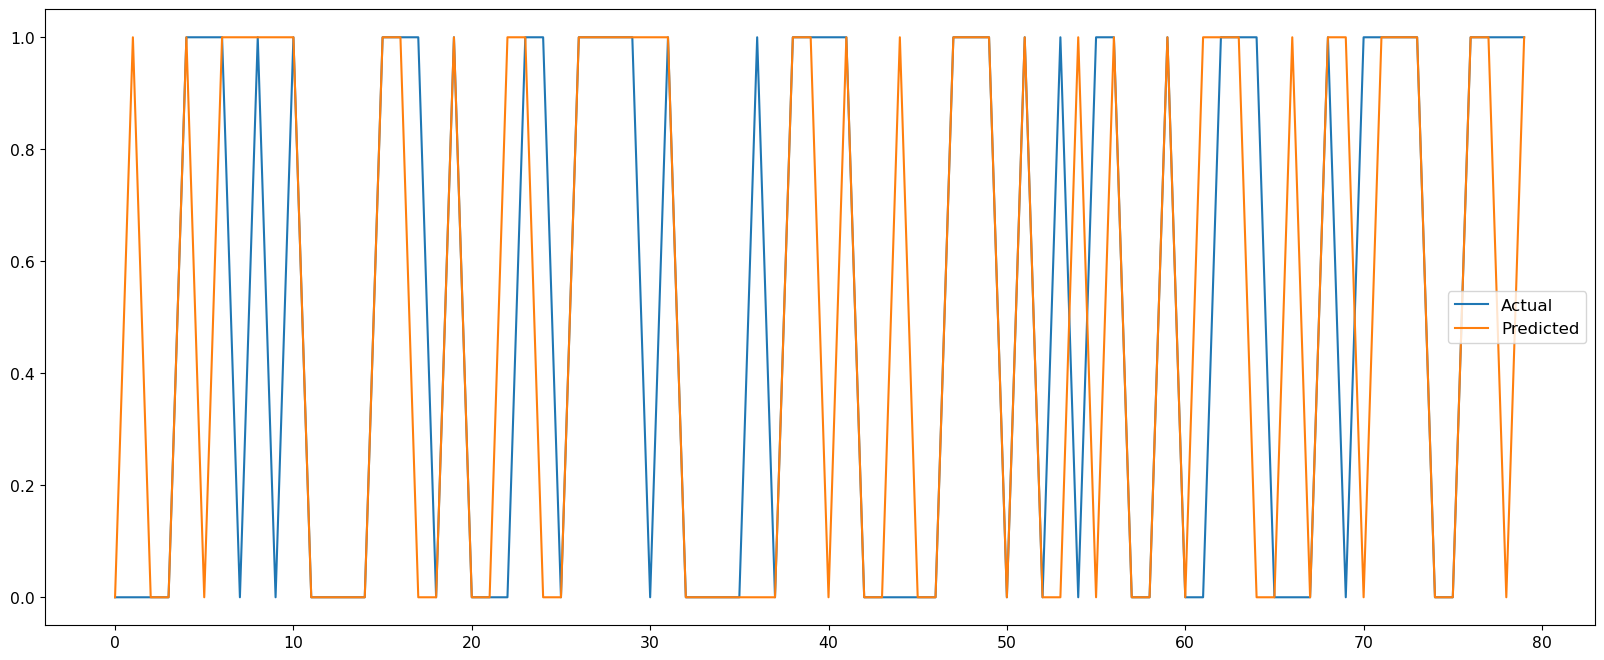

In [24]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

### 3. Decision Tree Classifier

In [172]:
dt = DecisionTreeClassifier()

In [171]:
list_criterion = ['gini', 'entropy']

list_max_features = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

list_max_depth = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

list_min_samples_split = [2, 4, 6, 8, 10, 12, 14, 16 , 18, 20, 22, 24]

list_min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

tuning_dict = dict(
    criterion = list_criterion, 
    max_features = list_max_features,
    max_depth = list_max_depth, 
    min_samples_split = list_min_samples_split,
    min_samples_leaf = list_min_samples_leaf
)

In [173]:
# Khởi tạo grid search cross validation
search = GridSearchCV(dt, tuning_dict, verbose=1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 29040 candidates, totalling 145200 fits


In [174]:
best_hp.best_params_

{'criterion': 'gini',
 'max_depth': 45,
 'max_features': 110,
 'min_samples_leaf': 20,
 'min_samples_split': 14}

In [25]:
dt_model_tuning = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 45,
    max_features = 110,
    min_samples_leaf = 20,
    min_samples_split = 14
)
dt_model_tuning.fit(x_train , y_train)

DecisionTreeClassifier(max_depth=45, max_features=110, min_samples_leaf=20,
                       min_samples_split=14)

Giá trị chính xác của model trên `training set`

In [26]:
dt_model_tuning.score(x_train , y_train)

0.7747105966162066

Giá trị chính xác của model trên `testing set`

In [27]:
dt_model_tuning.score(x_test , y_test)

0.7173333333333334

So sánh 10 giá trị đầu tiên giữa kết quả thực tế (Y_test) và kết quả dự đoán (Y_pred)

In [28]:
Y_pred = dt_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,1
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,0,0
8,1,1
9,0,0


Biểu đồ thể hiện kết quả thực tế và kết quả dự đoán của 80 giá trị đầu tiên 

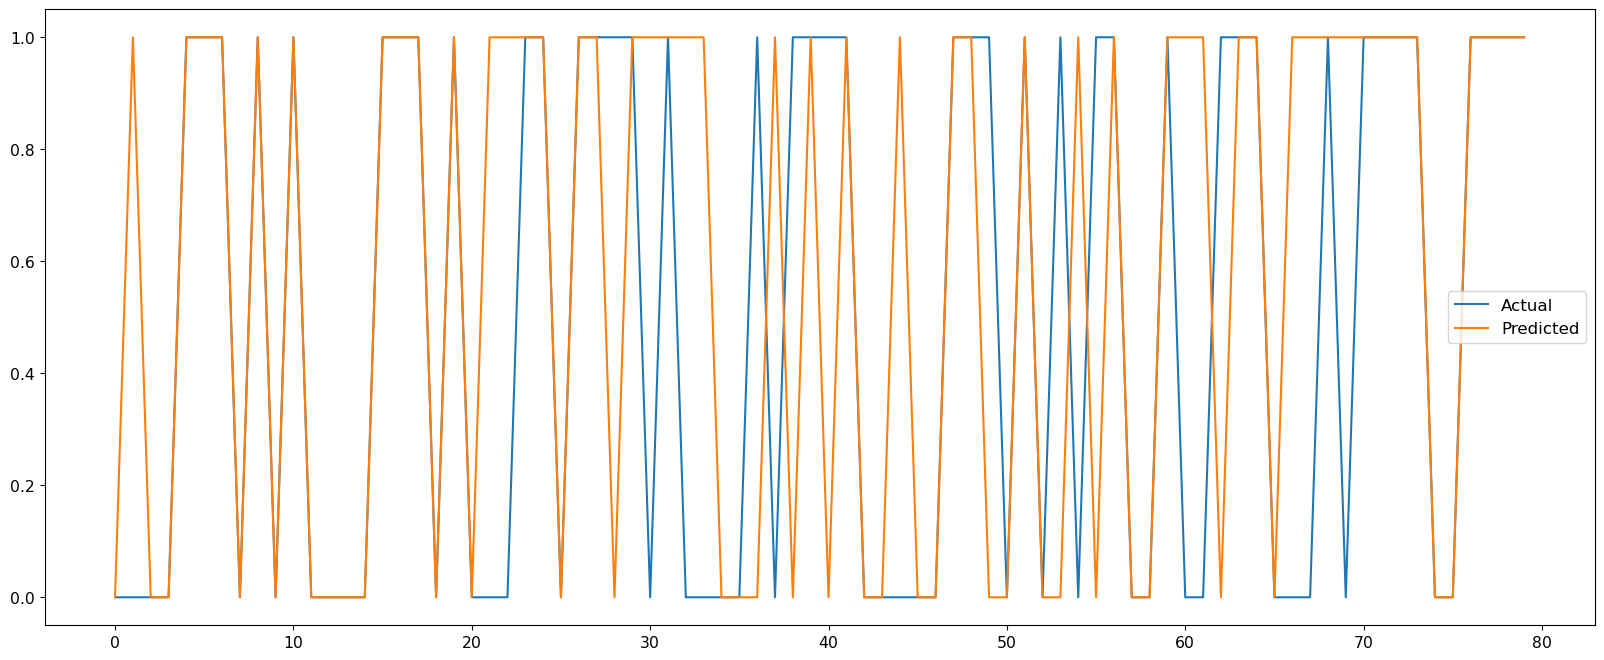

In [29]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

## Đánh giá mô hình

#### Hàm dùng để vẽ Confusion matrix

In [30]:
def draw_cf_matrix(label, pred, title):
    cf_matrix = confusion_matrix(label, pred)

    ax = plt.subplot()

    sns.heatmap(cf_matrix, annot=True, ax = ax, fmt='g', cmap='Greens')

    ax.set_xlabel('Predicted labels')

    ax.set_ylabel('True labels')

    ax.set_title('Confusion Matrix ' + title)

    ax.xaxis.set_ticklabels([0, 1])

    ax.yaxis.set_ticklabels([0, 1])

    cf_matrix

#### Kiểm tra các chỉ số độ chính xác (accuracy) của từng model

In [31]:
y_pred_lr = lr_model_tuning.predict(x_test)
score_lr = accuracy_score(y_test, y_pred_lr)

y_pred_knn = knn_model_tuning.predict(x_test)
score_knn = accuracy_score(y_test, y_pred_knn)

y_pred_dt = dt_model_tuning.predict(x_test)
score_dt = accuracy_score(y_test, y_pred_dt)

print('Logistic Regression: ' + str(score_lr))
print('K Neighbors Classifier: ' + str(score_knn))
print('Decision Tree Classifier: ' + str(score_dt))

Logistic Regression: 0.76
K Neighbors Classifier: 0.7413333333333333
Decision Tree Classifier: 0.7173333333333334


#### Vẽ các Confusion matrix cho từng model

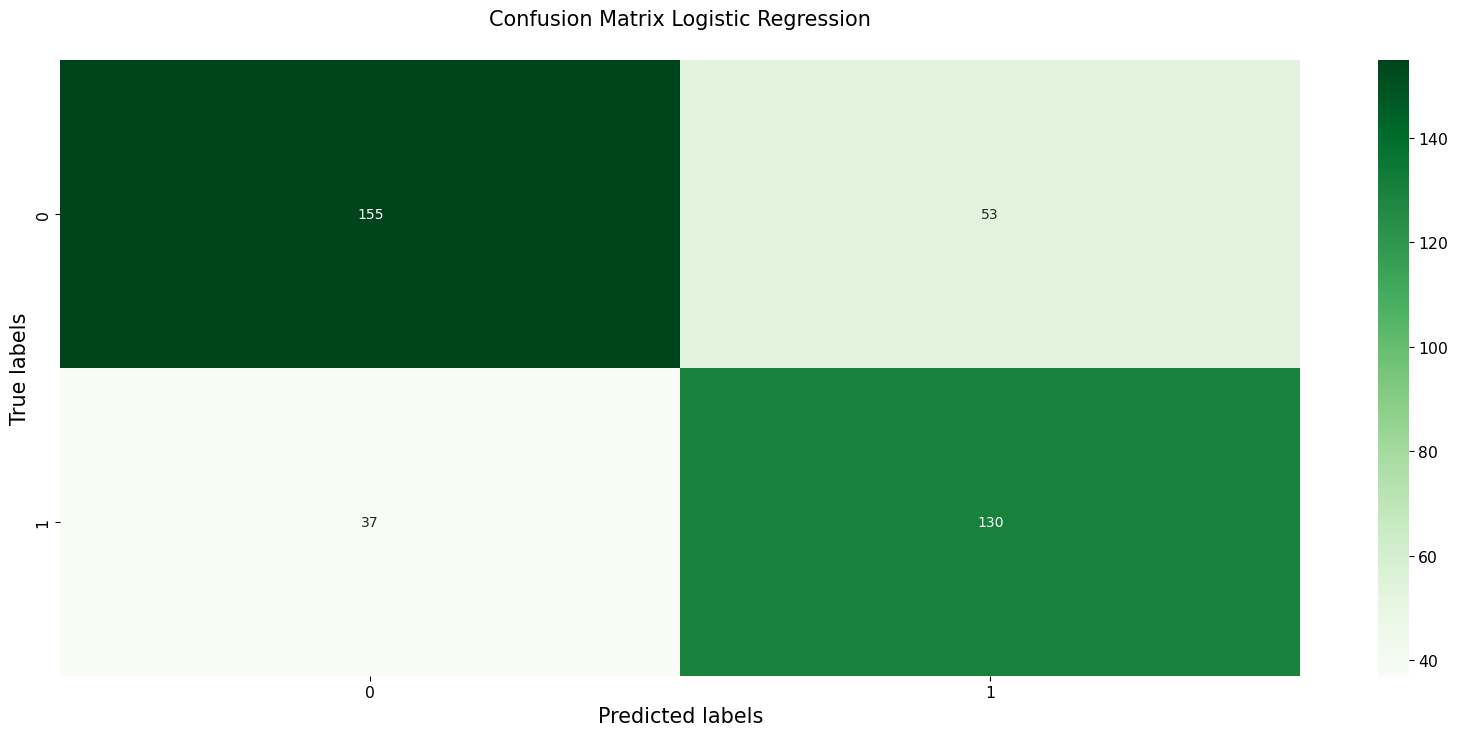

In [32]:
draw_cf_matrix(y_test, y_pred_lr, 'Logistic Regression')

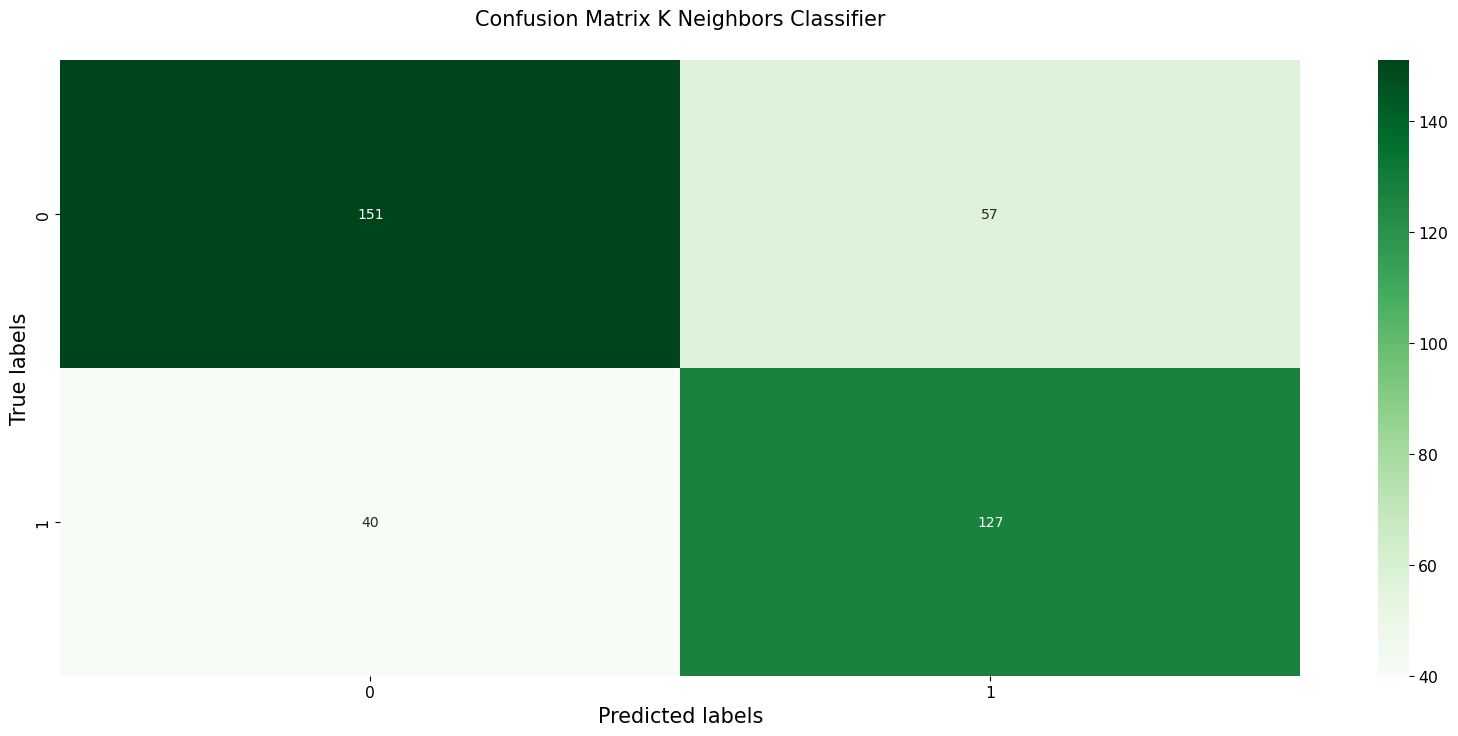

In [33]:
draw_cf_matrix(y_test, y_pred_knn, 'K Neighbors Classifier')

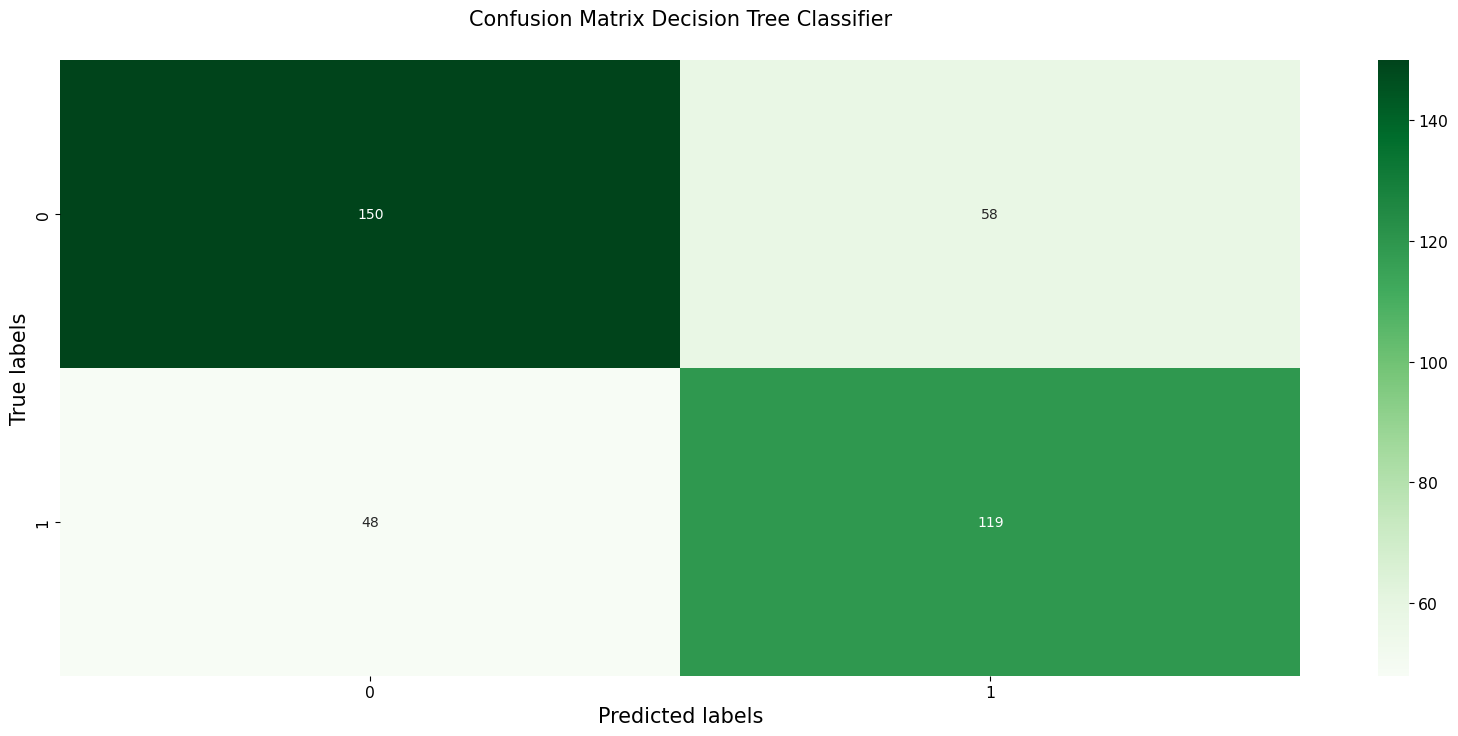

In [34]:
draw_cf_matrix(y_test, y_pred_dt, 'Decision Tree Classifier')

#### Báo cáo phân loại của các model (bao gồm accurancy, precision, recall, f-1 score)

In [35]:
print('Logistic Regression: \n' + classification_report(y_test, y_pred_lr))

Logistic Regression: 
              precision    recall  f1-score   support

           0       0.81      0.75      0.77       208
           1       0.71      0.78      0.74       167

    accuracy                           0.76       375
   macro avg       0.76      0.76      0.76       375
weighted avg       0.76      0.76      0.76       375



In [36]:
print('K Neighbors Classifier\n' + classification_report(y_test, y_pred_knn))

K Neighbors Classifier
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       208
           1       0.69      0.76      0.72       167

    accuracy                           0.74       375
   macro avg       0.74      0.74      0.74       375
weighted avg       0.75      0.74      0.74       375



In [37]:
print('Decision Tree Classifier\n' + classification_report(y_test, y_pred_dt))

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       208
           1       0.67      0.71      0.69       167

    accuracy                           0.72       375
   macro avg       0.71      0.72      0.72       375
weighted avg       0.72      0.72      0.72       375

